# Approximation of Koopman operators in Fock space

In [1]:
%load_ext nb_mypy
%nb_mypy Off
    
%matplotlib ipympl

Version 1.0.5


In [2]:
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import nlsa.function_algebra2 as fun
import nlsa.jax.fourier_t2 as t2
import scipy.sparse.linalg as sla
import seaborn as sns
import time
from functools import partial
from ipywidgets import interact, IntSlider
from jax import Array, jit, vmap
from jax.numpy.linalg import norm
from jax.scipy.linalg import toeplitz
from jax.scipy.special import i0
from more_itertools import take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from nlsa.dynamics import orbit, semigroup
from nlsa.abstract_algebra2 import compose_by, gelfand, make_linear_map,\
    make_linear_operator, make_qeval, multiply_by, normalize
from nlsa.function_algebra2 import compose, eval_at
from nlsa.jax.dynamics import flow, make_stepanoff_vector_field,\
    make_stepanoff_generator_fourier
from nlsa.jax.matrix_algebra import MatrixAlgebra, MatrixSpace
from nlsa.jax.vector_algebra import VectorAlgebra, make_fn_synthesis_operator
from nlsa.jax.special import iv0_ratio
from typing import Callable, Literal, TypeVar

In [3]:
jvmap = compose(jit, vmap)
vvmap = compose(vmap, vmap)
jvvmap = compose(jit, vvmap)

In [4]:
R = jnp.float32
R2 = Array
C = jnp.float64
S1 = Array
T2 = Array
A = Array
V = Array
V2 = Array
X = TypeVar('X')
Y = TypeVar('Y')
F = Callable[[X], Y]

## Circle rotation

In [5]:
alpha = 1.0
dt = 1
mu = jnp.pi
kappa = 10
n_iter = 8

In [6]:
def make_circle_rotation(a: R) -> Callable[[S1], S1]:
    """Make circle rotation map by angle a."""
    twopi = 2 * jnp.pi
    def phi(x: S1) -> S1:
        y = (x + a) % twopi
        return y
    return phi


def make_von_mises_density(kappa: R, mu: S1) -> Callable[[S1], R]:
    """Make Von Mises probability density function on the circle."""
    def f(x: S1) -> R:
        y = jnp.exp(kappa * jnp.cos(x - mu)) / i0(kappa)
        return y
    return f

### True dynamics

In [7]:
phi = make_circle_rotation(alpha * dt)
u = compose_by(fun, phi)
f = make_von_mises_density(kappa, mu)
f_orb = map(compose(jit, vmap), orbit(f, u))
fn = take(n_iter + 1, f_orb) 

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=8), Output()), _dom_cla…

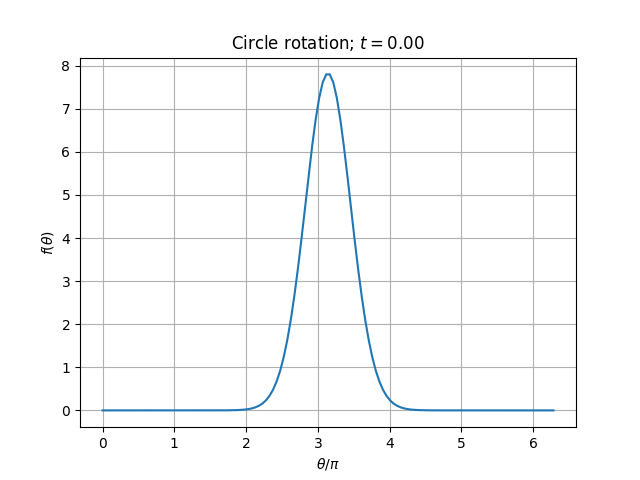

In [8]:
i_fig = 1
n_plt_x = 128

x = jnp.linspace(0, 2 * jnp.pi, n_plt_x)

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)


@interact(j=j_slider) 
def plotfunc1(j):
    t = j * dt
    f = fn[j]
    fx = f(x)
    ax.cla()
    im = ax.plot(x, fx)
    ax.grid(True)
    ax.set_xlabel('$\\theta/\\pi$')
    ax.set_ylabel('$f(\\theta)$')
    ax.set_title(f"Circle rotation; $t = {t:.2f}$")

### Finite-dimensional quantum approximation

In [9]:
def toeplitz_mat(v: V2) -> A:
    """Compute Toeplitz matrix from Fourier expansion coefficients.
    
    The input vector v has dimension 4*k + 1, where k is the maximal Fourier
    wavenumber. The output multiplication operator acts on vectors of
    dimension 2*k + 1.
    """
    
    k = (v.shape[-1] - 1) // 4
    c = v[2 * k:]
    r = jnp.flip(v[:2 * k + 1])
    return  toeplitz(c, r)

In [10]:
def make_circle_rotation_fourier(a: R) -> Callable[[int], C]:
    """Make function that computes eigenvalues of circle rotation."""
    
    def rot_eig(k: int) -> C:
        return jnp.exp(1j * k * a)
    
    return vmap(rot_eig)


def von_mises_fourier(k_max: int, kappa: R, mu: S1) -> V:
    """Compute Fourier coefficients of the von Mises density."""
    ks = jnp.arange(-k_max, k_max + 1, dtype=jnp.float32)
    return iv0_ratio(jnp.abs(ks), kappa) * jnp.exp(-1j * ks * mu)
                         
    
def make_von_mises_feature_map(kappa: R, k_max: int) -> Callable[[S1], V]:
    """Make von Mises feature map on circle."""
    return partial(von_mises_fourier, k_max, kappa)

In [11]:
k_max = 32
kappa_eval = 50.

vec = VectorAlgebra(dim=(2*k_max + 1), dtype=jnp.complex64)
mat = MatrixAlgebra(dim=(2*k_max + 1), dtype=jnp.complex64, hilb=vec)

phi_fourier = make_circle_rotation_fourier(alpha * dt)
u_vec = vec.star(phi_fourier(jnp.arange(-k_max, k_max + 1)))
u_op = multiply_by(vec, u_vec)
f_mat = toeplitz_mat(von_mises_fourier(2 * k_max, kappa, mu))
xi = compose(partial(normalize, vec),
             make_von_mises_feature_map(kappa_eval, k_max))
u_semi = semigroup(u_op)
xi_orb = map(compose_by(fun, xi), u_semi)
qeval = map(partial(make_qeval, mat), xi_orb) 
qeval_f = map(partial(compose, gelfand(mat, f_mat)), qeval)
vqeval_f = map(jvmap, qeval_f)
fqn = take(n_iter + 1, vqeval_f) 

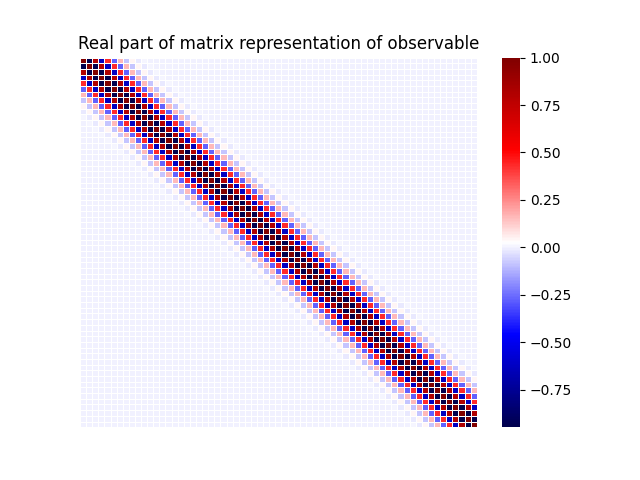

In [12]:
i_fig = 2

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax2 = sns.heatmap(jnp.real(f_mat), linewidth=0.5, cmap='seismic')
ax.set_axis_off()
ax2.set_title("Real part of matrix representation of observable")
plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=8), Output()), _dom_cla…

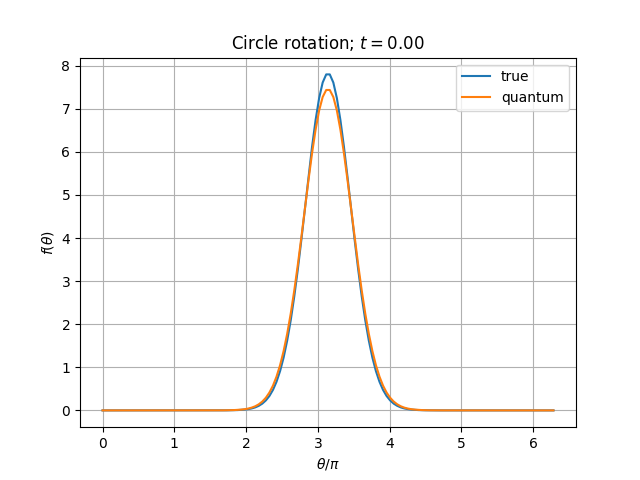

In [13]:
i_fig = 3
n_plt_x = 128

x = jnp.linspace(0, 2 * jnp.pi, n_plt_x)

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc3(j):
    t = j * dt
    f = fn[j]
    fx = f(x)
    fq = fqn[j]
    fqx = fq(x).real
    ax.cla()
    im = ax.plot(x, fx, label='true')
    imq = ax.plot(x, fqx, label='quantum')
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('$\\theta/\\pi$')
    ax.set_ylabel('$f(\\theta)$')
    ax.set_title(f"Circle rotation; $t = {t:.2f}$")

## Torus rotation

In [14]:
alpha2 = jnp.array([1.0, jnp.sqrt(30)])
dt2 = 1
mu2 = jnp.array([jnp.pi, jnp.pi])
kappa2 = jnp.array([10., 10.]) 
n_iter2 = 8

In [15]:
def make_torus_rotation(a: R2) -> Callable[[T2], T2]:
    """Make torus rotation map by angles a."""
    twopi = 2 * jnp.pi
    def phi(x: T2) -> T2:
        y = (x + a) % twopi
        return y
    return phi


def make_torus_von_mises_density(kappa: R2, mu: T2) -> Callable[[T2], R]:
    """Make Von Mises probability density function on the torus."""
    f0 = make_von_mises_density(kappa[0], mu[0])
    f1 = make_von_mises_density(kappa[1], mu[1])
    
    def f(x: T2) -> R:
        return f0(x[0]) * f1(x[1])
    
    return f

### True dynamics

In [16]:
phi2 = make_torus_rotation(alpha2 * dt2)
u2 = compose_by(fun, phi2)
f2 = make_torus_von_mises_density(kappa2, mu2)
f2_orb = map(jvvmap, orbit(f2, u2))
f2s = take(n_iter2 + 1, f2_orb) 

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=8), Output()), _dom_cla…

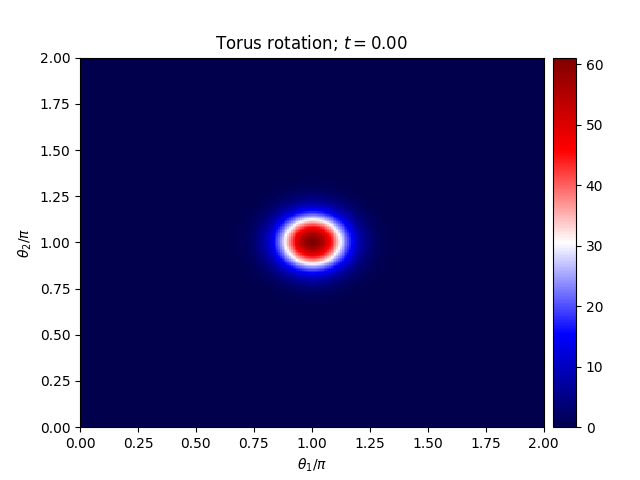

In [17]:
i_fig = 4
n_plt_x = 256

theta = jnp.linspace(0, 2*jnp.pi, n_plt_x)
x1, x2 = jnp.meshgrid(theta, theta)
x = jnp.concatenate((x1[:-1, :-1, jnp.newaxis], x2[:-1, :-1, jnp.newaxis]), 
                    axis=2)
x1 = x1 / jnp.pi
x2 = x2 / jnp.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
j_slider = IntSlider(value=0, min=0, max=n_iter2, continuous_update=False)


@interact(j=j_slider) 
def plotfunc4(j):
    t = j * dt2
    f = f2s[j]
    fx = f(x)
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic")
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Torus rotation; $t = {t:.2f}$")

### Finite-dimensional quantum approximation

In [18]:
def make_von_mises_feature_map2(kappa: R, k_max: int) -> Callable[[T2], V2]:
    """Make von Mises feature map on torus."""
    feat1 = make_von_mises_feature_map(kappa, k_max)
    
    def feat2(x: T2) -> V2:
        return jnp.kron(feat1(x[0]), feat1(x[1]))
    
    return feat2

In [19]:
k_max = 4
kappa_eval = 50.

vec2 = VectorAlgebra(dim=(2*k_max + 1)**2, dtype=jnp.complex64)
mat2 = MatrixAlgebra(dim=(2*k_max + 1)**2, dtype=jnp.complex64, hilb=vec)

ks = jnp.arange(-k_max, k_max + 1)
phis_fourier = map(make_circle_rotation_fourier, alpha2 * dt)
u_vecs = list(map(vec.star, map(eval_at(ks), phis_fourier)))
u2_vec = jnp.kron(u_vecs[0], u_vecs[1])
u2_op = multiply_by(vec2, u2_vec)
f_mats = [toeplitz_mat(von_mises_fourier(k, kappa, mu))\
          for (k, kappa, mu) in zip((2*k_max, 2*k_max), kappa2, mu2)] 
f2_mat = jnp.kron(f_mats[0], f_mats[1])
xi2 = compose(partial(normalize, vec2),
              make_von_mises_feature_map2(kappa_eval, k_max))
u2_semi = semigroup(u2_op)
xi2_orb = map(compose_by(fun, xi2), u2_semi)
qeval2 = map(partial(make_qeval, mat), xi2_orb) 
qeval2_f = map(partial(compose, gelfand(mat, f2_mat)), qeval2)
vqeval2_f = map(jvvmap, qeval2_f)
f2qs = take(n_iter + 1, vqeval2_f) 

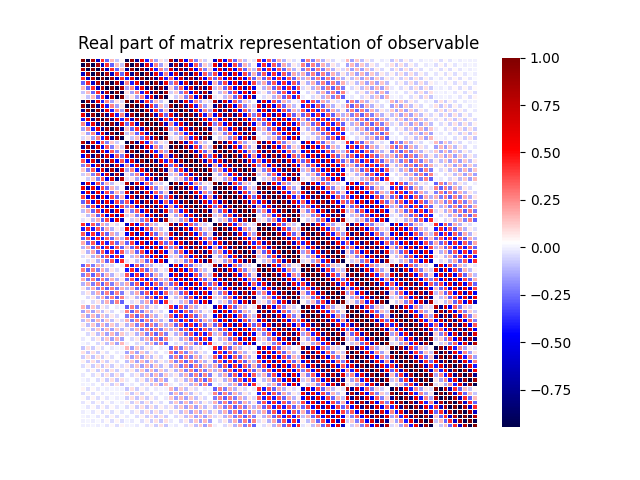

In [20]:
i_fig = 5

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax2 = sns.heatmap(jnp.real(f2_mat), linewidth=0.5, cmap='seismic')
ax.set_axis_off()
ax2.set_title("Real part of matrix representation of observable")
plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=8), Output()), _dom_cla…

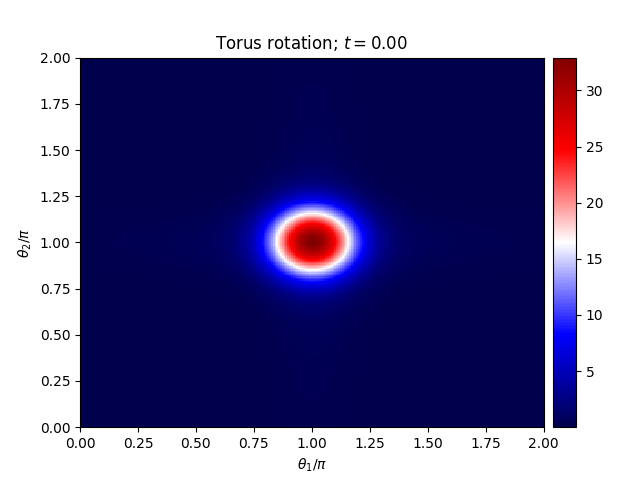

In [21]:
i_fig = 6
n_plt_x = 256

theta = jnp.linspace(0, 2*jnp.pi, n_plt_x)
x1, x2 = jnp.meshgrid(theta, theta)
x = jnp.concatenate((x1[:-1, :-1, jnp.newaxis], x2[:-1, :-1, jnp.newaxis]), 
                    axis=2)
x1 = x1 / jnp.pi
x2 = x2 / jnp.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
j_slider = IntSlider(value=0, min=0, max=n_iter2, continuous_update=False)


@interact(j=j_slider) 
def plotfunc6(j):
    t = j * dt2
    f = f2qs[j]
    fx = f(x).real
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic")
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Torus rotation; $t = {t:.2f}$")

## Stepanoff flow

In [22]:
alphaS = jnp.sqrt(20.)
dtS = 0.1
muS = jnp.array([jnp.pi, jnp.pi])
kappaS = jnp.array([1., 1.]) 
n_iterS = 64

In [23]:
def make_stepanoff_vector_field(alpha: float) -> Callable[[T2], R2]:
    """Make vector field of the Stepanoff flow on the 2-torus."""

    def v(x: T2) -> R2:
        y = jnp.empty(2)
        y = y.at[1].set(alpha * (1 - jnp.cos(x[0] - x[1])))
        y = y.at[0].set(y[1] + (1 - alpha) * (1 - jnp.cos(x[1])))
        return y
    return v

### True dynamics

In [24]:
vS = make_stepanoff_vector_field(alphaS)
phiS = flow(vS, dtS)
uS = compose_by(fun, phiS)
fS = make_torus_von_mises_density(kappaS, muS)
fS_orb = map(jvvmap, orbit(fS, uS))
f2Ss = take(n_iterS + 1, fS_orb) 

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=64), Output()), _dom_cl…

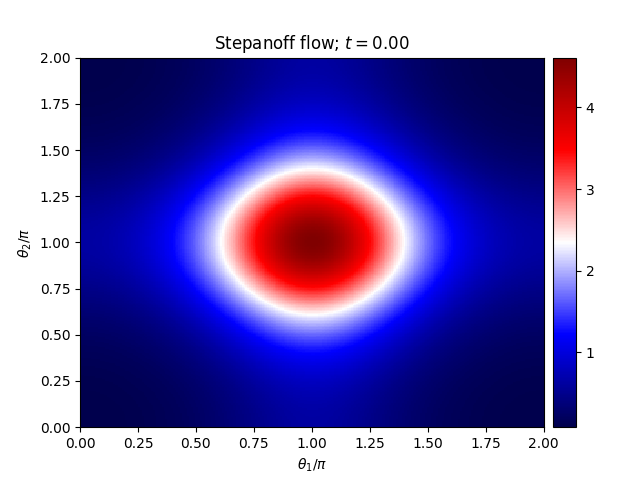

In [25]:
i_fig = 7
n_plt_x = 256

theta = jnp.linspace(0, 2*jnp.pi, n_plt_x)
x1, x2 = jnp.meshgrid(theta, theta)
x = jnp.concatenate((x1[:-1, :-1, jnp.newaxis], x2[:-1, :-1, jnp.newaxis]), 
                    axis=2)
x1 = x1 / jnp.pi
x2 = x2 / jnp.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
j_slider = IntSlider(value=0, min=0, max=n_iterS, continuous_update=False)


@interact(j=j_slider) 
def plotfunc7(j):
    t = j * dtS
    f = f2Ss[j]
    fx = f(x)
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic")
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Stepanoff flow; $t = {t:.2f}$")

### Finite-dimensional quantum approximation

In [26]:
def make_rkha_weight_function_s1(p: R, tau: R) -> Callable[[int], R]:
    """Make inverse subexponential weight function on the dual group of S1."""
    
    def lamb(k: int) -> R:
        return jnp.exp(-tau * jnp.abs(jnp.float32(k))**p)
    return lamb

def unit_fourier_s1(k_max: int) -> V:
    """Compute Fourier representation of unit function on S1."""
    n = 2 * k_max + 1
    u = jnp.zeros(n, dtype=jnp.float32)
    u = u.at[k_max].set(1.0)
    return u
    
    
def unit_fourier_t2(k_max: int) -> V2:
    """Compute Fourier representation of unit functon on T2."""
    u1 = unit_fourier_s1(k_max)
    return jnp.kron(u1, u1)


def make_fourier_involution_t2(k_max: int) -> Callable[[V], V]:
    """Make involution for Fourier coefficients of functions on T2."""
    n = 2*k_max + 1
    
    def star(v: V) -> V:
        w = t2.flip_conj(jnp.reshape(v, (n, n)))
        return jnp.reshape(w, n**2)
    
    return star

In [27]:
k_max = 16
tau = 0.01
p_rkha = 0.25
n_fourier = (2*k_max + 1)**2
n_eigs_compute = round((n_fourier - 1) / 2) 

vecF = VectorAlgebra(dim=n_fourier, dtype=jnp.complex64)

v_fourier = make_stepanoff_generator_fourier(alphaS, (k_max, k_max),
                                             hermitian=True)
lamb = make_rkha_weight_function_s1(p_rkha, tau)
vlamb = vmap(lamb)
lamb_vec = vlamb(jnp.arange(-k_max, k_max + 1))
kernel_vec = jnp.kron(lamb_vec, lamb_vec)
kernel_op = multiply_by(vecF, kernel_vec)
v_reg = compose(kernel_op, compose(v_fourier, kernel_op))
matvec = jit(v_reg)
matmat = jit(vmap(v_reg, in_axes=1, out_axes=1))
a = sla.LinearOperator(shape=(n_fourier, n_fourier), dtype=jnp.float32,
                       matvec=matvec, matmat=matmat)
[omegas_unsorted, zs_unsorted] = sla.eigsh(a, n_eigs_compute, which='LA')
engys_unsorted = jnp.sum(jnp.abs(zs_unsorted)**2 / kernel_vec[:, jnp.newaxis],
                         axis=0) - 1.0

In [28]:
n_eigs_keep = n_eigs_compute 
n_koopman = (2 * n_eigs_keep + 1) 

involution = vmap(make_fourier_involution_t2(k_max),
                  in_axes=1, out_axes=1)

matFK = MatrixSpace(dim=(n_koopman, n_fourier), dtype=jnp.complex64)
matKF = MatrixSpace(dim=(n_fourier, n_koopman), dtype=jnp.complex64)

isort = jnp.argsort(engys_unsorted)[0 : n_eigs_keep] 
engys = jnp.concatenate((engys_unsorted[isort[::-1]],
                         0.0,
                         engys_unsorted[isort]),
                        axis=None) 
omegas = jnp.concatenate((-omegas_unsorted[isort[::-1]],
                          0.0,
                          omegas_unsorted[isort]),
                         axis=None)
zs = jnp.concatenate((involution(zs_unsorted[:, isort[::-1]]),
                      unit_fourier_t2(k_max)[:, jnp.newaxis], 
                      zs_unsorted[:, isort]),
                     axis=1)

basis = t2.make_fourier_basis((jnp.arange(-k_max, k_max + 1),
                               jnp.arange(-k_max, k_max + 1)))
synth = make_fn_synthesis_operator(basis)

to_fourier_basis_mat = zs
to_koopman_eigenbasis_mat = jnp.conjugate(zs.T)
to_fourier_basis = make_linear_map(matKF, to_fourier_basis_mat)
to_koopman_eigenbasis = make_linear_map(matFK, to_koopman_eigenbasis_mat)

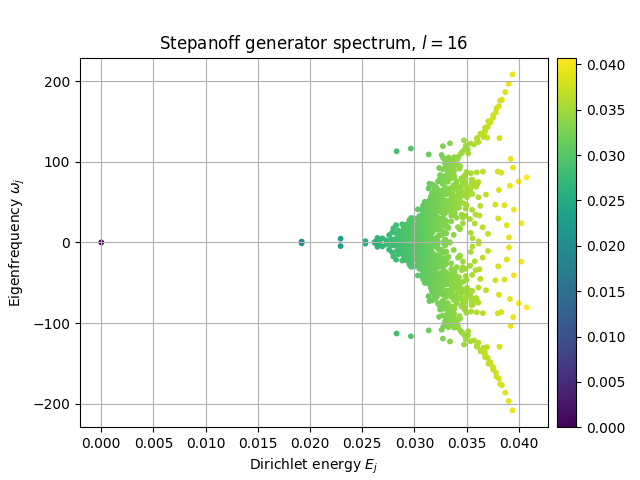

In [29]:
i_fig = 8

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="4%", pad="2%")
im = ax.scatter(engys, omegas, s=10, c=engys)
cb = fig.colorbar(im, cax=cax)
ax.grid(True)
ax.set_xlabel("Dirichlet energy $E_j$")
ax.set_ylabel("Eigenfrequency $\\omega_j$")
ax.set_title(f"Stepanoff generator spectrum, $l={k_max}$")
plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=544, min=-544), Output(…

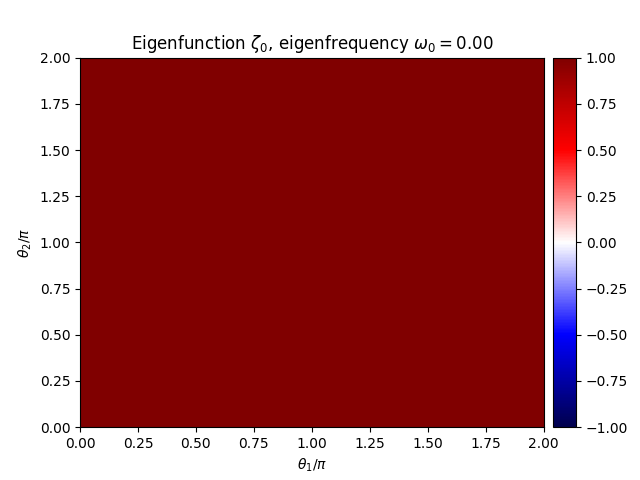

In [30]:
i_fig = 9
n_plt_x = 256

theta = jnp.linspace(0, 2*jnp.pi, n_plt_x)
x1, x2 = jnp.meshgrid(theta, theta)
x = jnp.concatenate((x1[:-1, :-1, jnp.newaxis], x2[:-1, :-1, jnp.newaxis]), 
                    axis=2)
x1 = x1 / jnp.pi
x2 = x2 / jnp.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
j_slider = IntSlider(value=0, min=-n_eigs_keep, max=n_eigs_keep, continuous_update=False)


@interact(j=j_slider) 
def plotfunc9(j):
    j0 = j + n_eigs_keep
    f = jvvmap(synth(zs[:, j0]))
    fx = f(x).real
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx,
                       norm=mpl.colors.CenteredNorm(), cmap="seismic")
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Eigenfunction $\zeta_{{{j}}}$, "
                 f"eigenfrequency $\omega_{{{j}}} = {omegas[j0]:.2f}$")

In [31]:
vecK = VectorAlgebra(dim=n_koopman, dtype=jnp.complex64)
matK = MatrixAlgebra(dim=n_koopman, dtype=jnp.complex64, hilb=vec)
matF = MatrixAlgebra(dim=n_fourier, dtype=jnp.complex64, hilb=vec)

uS_vec = jnp.exp(1j * omegas * dtS)
uS_op = multiply_by(vecK, vecK.star(uS_vec))
fS_mats_fourier = [toeplitz_mat(von_mises_fourier(k, kappa, mu))\
                   for (k, kappa, mu) in zip((2*k_max, 2*k_max), kappaS, muS)] 
fS_mat_fourier = jnp.kron(fS_mats_fourier[0], fS_mats_fourier[1])
fS_mat = to_koopman_eigenbasis_mat @ fS_mat_fourier @ to_fourier_basis_mat
xiS_fourier = make_von_mises_feature_map2(kappa_eval, k_max)
xiS = compose(partial(normalize, vecK),
              compose(to_koopman_eigenbasis, xiS_fourier))
uS_semi = semigroup(uS_op)
xiS_orb = map(compose_by(fun, xiS), uS_semi)
qevalS = map(partial(make_qeval, matK), xiS_orb) 
qevalS_f = map(partial(compose, gelfand(matK, fS_mat)), qevalS)
vqevalS_f = map(jvvmap, qevalS_f)
fSqs = take(n_iterS + 1, vqevalS_f) 

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=64), Output()), _dom_cl…

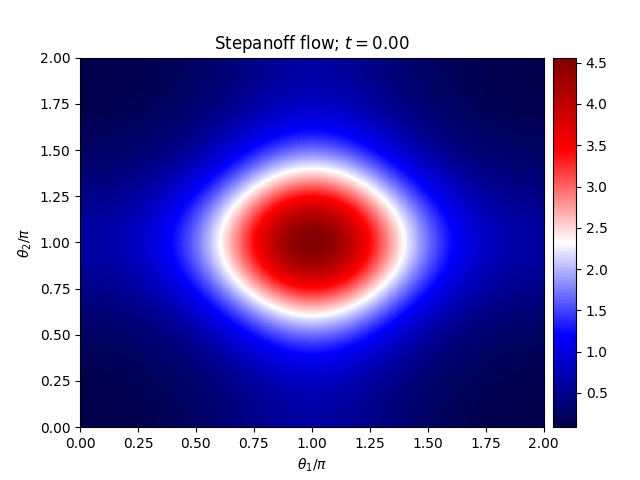

In [32]:
i_fig = 9
n_plt_x = 512

theta = jnp.linspace(0, 2*jnp.pi, n_plt_x)
x1, x2 = jnp.meshgrid(theta, theta)
x = jnp.concatenate((x1[:-1, :-1, jnp.newaxis], x2[:-1, :-1, jnp.newaxis]), 
                    axis=2)
x1 = x1 / jnp.pi
x2 = x2 / jnp.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
j_slider = IntSlider(value=0, min=0, max=n_iterS, continuous_update=False)


@interact(j=j_slider) 
def plotfunc9(j):
    t = j * dtS
    f = fSqs[j]
    fx = f(x).real
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic")
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Stepanoff flow; $t = {t:.2f}$")

In [34]:
ll = make_rkha_weight_function_s1(0.25, 0.01)
ll(jnp.array([3]))

Array([0.9869255], dtype=float32)

In [35]:
in_plt_x = 128
n_iter = 50
plt_range = (-1, 70)
i_fig = 5

f_hat_orb = orbit(f_hat, u)
f_orb  = map(synth_zeta, f_hat_orb)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = np.real(f(x))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("Classical approximation of ergodic rotation; "
                 f"$t = {t:.2f}$")
    plt.show()

NameError: name 'f_hat' is not defined

### Quantum mechanical approximation

In [ ]:
epsilon = 0.2

u_adj = fmap(multiply_by(vec, np.exp(-omega * dt)))
f_mult = to_zeta_mat(vm_mult_op((kappa, kappa), (l, l)))
make_qm_recon = partial(qm_recon, f_mult)
xi = compose(to_zeta_vec, feature_map((epsilon, epsilon), (l, l)))

In [ ]:
n_plt_x = 128
n_iter = 50
n_par = 3
plt_range = (-1, 70)
i_fig = 6

pl = Pool(n_par)
xi_orb = orbit(xi, u_adj)
f_orb  = map(make_qm_recon, xi_orb)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = np.real(pl.map(f, x))
    #fx = np.real(f(x))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("QM approximation of ergodic rotation; "
                 f"$t = {t:.2f}$")
    plt.show()

## Stepanoff flow

In [ ]:
alpha = np.sqrt(20)
dt = 0.1
kappa = 10

### True dynamics

In [ ]:
u = compose_by(fun, flow(stepanoff_vec(alpha), dt))
f = vm((kappa, kappa))

In [ ]:
n_plt_x = 64
n_iter = 100
n_par = 6
plt_range = (-1, 70)
i_fig = 11

pl = Pool(n_par)
f_orb = orbit(f, u)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi
x = np.reshape(x, ((n_plt_x - 1) ** 2, 2))

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = pl.map(f, x)
    fx = np.reshape(fx, (n_plt_x - 1, n_plt_x - 1))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Stepanoff flow; $t = {t:.2f}$")
    plt.show()

### RKHS regularization

In [ ]:
l = 3
i_fig = 12

v: csr_matrix = stepanoff_generator(alpha, l)

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
im = ax.matshow(np.imag(v.todense()))
cb = fig.colorbar(im, cax=cax)
ax.set_xlabel("$j$")
ax.set_ylabel("$i$")
ax.set_title(f"Stepanoff generator matrix, $l={l}$")
plt.show()

In [ ]:
l = 8
p = 0.5
tau = 0.0005

regularized_eig = rkha_eig(p, tau, l)
v: csr_matrix = stepanoff_generator(alpha, l)
omega, c, e = regularized_eig(v.todense())

to_zeta_vec = compose_by(mat, c)
to_zeta_mat = conjugate_by(mat, c.T.conj(), mat, c)
phi = f2.fourier_basis(f2.dual_group((l, l)))
zeta = compose(to_zeta_vec, phi)
synth_phi = partial(fun.synthesis, phi)
synth_zeta = partial(fun.synthesis, zeta)

In [ ]:
i_fig = 13

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="4%", pad="2%")
im = ax.scatter(e, np.imag(omega), s=10, c=e)
cb = fig.colorbar(im, cax=cax)
ax.grid(True)
ax.set_xlabel("Dirichlet energy $E_j$")
ax.set_ylabel("Eigenfrequency $\\omega_j$")
ax.set_title(f"Stepanoff generator spectrum, $l={l}$")
plt.show()

In [ ]:
n_plt_x = 64
n_plt_eig = 20
i_fig = 14

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
j_slider = IntSlider(value=0, min=0, max=n_plt_eig, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    f = synth_phi(c[:, j])
    fx = np.real(f(x))
    om = np.imag(omega[j])
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Stepanoff eigenfunction $\zeta_{{{j}}}$, "
                  + f"$\omega_{{{j}}} = {om:.3f}$")
    plt.show()

### Classical approximation

In [ ]:
f_hat = np.inner(np.conj(c.T), vm_fourier((kappa, kappa), (l, l)))
u = multiply_by(vec, np.exp(omega * dt))

In [ ]:
n_plt_x = 64
n_iter = 100
plt_range = (-1, 70)
i_fig = 15

f_hat_orb = orbit(f_hat, u)
f_orb  = map(synth_zeta, f_hat_orb)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = np.real(f(x))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("Classical approximation of Stepanoff flow; "
                 f"$t = {t:.2f}$")
    plt.show()

### Quantum mechanical approximation

In [ ]:
epsilon = 0.1

u_adj = fmap(multiply_by(vec, np.exp(-omega * dt)))
f_mult = to_zeta_mat(vm_mult_op((kappa, kappa), (l, l)))
make_qm_recon = partial(qm_recon, f_mult)
xi = compose(to_zeta_vec, feature_map((epsilon, epsilon), (l, l)))

In [ ]:
n_plt_x = 64
n_iter = 50
n_par = 6
plt_range = (-1, 70)
i_fig = 16

pl = Pool(n_par)
xi_orb = orbit(xi, u_adj)
f_orb  = map(make_qm_recon, xi_orb)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = np.real(pl.map(f, x))
    #fx = np.real(f(x))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("QM approximation of Stepanoff flow; "
                 f"$t = {t:.2f}$")
    plt.show()